In [39]:
from logging import warning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings ('ignore')

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, silhouette_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot

In [2]:
df_customer = pd.read_csv(r'/content/drive/MyDrive/Machine Learning/CSV/Final Project PBI internship Kalbe Nutrionals DS/customer.csv', delimiter=';')
df_product = pd.read_csv(r'/content/drive/MyDrive/Machine Learning/CSV/Final Project PBI internship Kalbe Nutrionals DS/product.csv', delimiter=';')
df_store = pd.read_csv(r'/content/drive/MyDrive/Machine Learning/CSV/Final Project PBI internship Kalbe Nutrionals DS/store.csv', delimiter=';')
df_transaction = pd.read_csv(r'/content/drive/MyDrive/Machine Learning/CSV/Final Project PBI internship Kalbe Nutrionals DS/transaction.csv', delimiter=';')

In [40]:
df_customer.shape, df_product.shape, df_store.shape, df_transaction.shape

((447, 5), (10, 3), (14, 6), (5020, 8))

In [41]:
df_customer.head()

,CustomerID,Age,Gender,Marital Status,Income
0,1,55,1,Married,5.12
1,2,60,1,Married,6.23
2,3,32,1,Married,9.17
3,4,31,1,Married,4.87
4,5,58,1,Married,3.57


In [42]:
df_product.head()

,ProductID,Product Name,Price
0,P1,Choco Bar,8800
1,P2,Ginger Candy,3200
2,P3,Crackers,7500
3,P4,Potato Chip,12000
4,P5,Thai Tea,4200


In [43]:
df_store.head()

,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
0,1,Prima Tendean,Prima,Modern Trade,-6.200000,106.816666
1,2,Prima Kelapa Dua,Prima,Modern Trade,-6.914864,107.608238
2,3,Prima Kota,Prima,Modern Trade,-7.797068,110.370529
3,4,Gita Ginara,Gita,General Trade,-6.966667,110.416664
4,5,Bonafid,Gita,General Trade,-7.250445,112.768845


In [44]:
df_transaction.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
0,TR11369,328,2022-01-01,P3,7500,4,30000,12
1,TR16356,165,2022-01-01,P9,10000,7,70000,1
2,TR1984,183,2022-01-01,P1,8800,4,35200,4
3,TR35256,160,2022-01-01,P1,8800,7,61600,4
4,TR41231,386,2022-01-01,P9,10000,1,10000,4


In [45]:
df_customer['Income'] = df_customer['Income'].replace('[,]', '.',regex=True).astype('float')
df_store['Latitude'] = df_store['Latitude'].replace('[,]', '.',regex=True).astype('float')
df_store['Longitude'] = df_store['Longitude'].replace('[,]', '.',regex=True).astype('float')
df_transaction['Date'] = pd.to_datetime(df_transaction['Date'])

In [46]:
df_merge = pd.merge(df_transaction, df_customer, on=['CustomerID'])
df_merge = pd.merge(df_merge, df_product.drop(columns=['Price']), on=['ProductID'])
df_merge = pd.merge(df_merge, df_store, on=['StoreID'])

In [47]:
df_merge.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Product Name,StoreName,GroupStore,Type,Latitude,Longitude
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,Married,10.53,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
1,TR89318,183,2022-07-17,P3,7500,1,7500,12,27,1,Single,0.18,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
2,TR9106,123,2022-09-26,P3,7500,4,30000,12,34,0,Married,4.36,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
3,TR4331,335,2022-08-01,P3,7500,3,22500,12,29,1,Single,4.74,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
4,TR6445,181,2022-10-01,P3,7500,4,30000,12,33,1,Married,9.94,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554


In [48]:
df_regresi = df_merge.groupby(['Date']).agg({
    'Qty' : 'sum'
}).reset_index()

In [49]:
df_regresi

,Date,Qty
0,2022-01-01,49
1,2022-01-02,50
2,2022-01-03,76
3,2022-01-04,98
4,2022-01-05,67
...,...,...
360,2022-12-27,70
361,2022-12-28,68
362,2022-12-29,42
363,2022-12-30,44


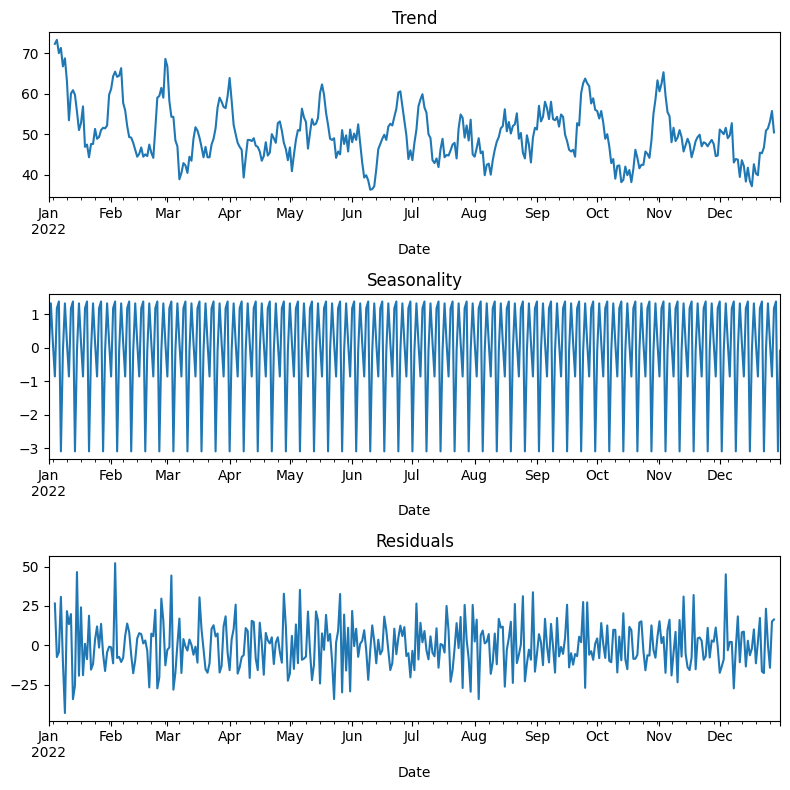

In [50]:
decomposed = seasonal_decompose(df_regresi.set_index('Date'))
plt.figure(figsize=(8, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

In [51]:
cut_off = round(df_regresi.shape[0] * 0.9)
df_train = df_regresi[:cut_off]
df_test = df_regresi[cut_off:].reset_index(drop=True)
df_train.shape, df_test.shape

((328, 2), (37, 2))

In [52]:
df_train

,Date,Qty
0,2022-01-01,49
1,2022-01-02,50
2,2022-01-03,76
3,2022-01-04,98
4,2022-01-05,67
...,...,...
323,2022-11-20,55
324,2022-11-21,55
325,2022-11-22,49
326,2022-11-23,40


In [53]:
df_test

,Date,Qty
0,2022-11-25,55
1,2022-11-26,40
2,2022-11-27,53
3,2022-11-28,50
4,2022-11-29,55
5,2022-11-30,45
6,2022-12-01,35
7,2022-12-02,34
8,2022-12-03,41
9,2022-12-04,98


<Axes: xlabel='Date', ylabel='Qty'>

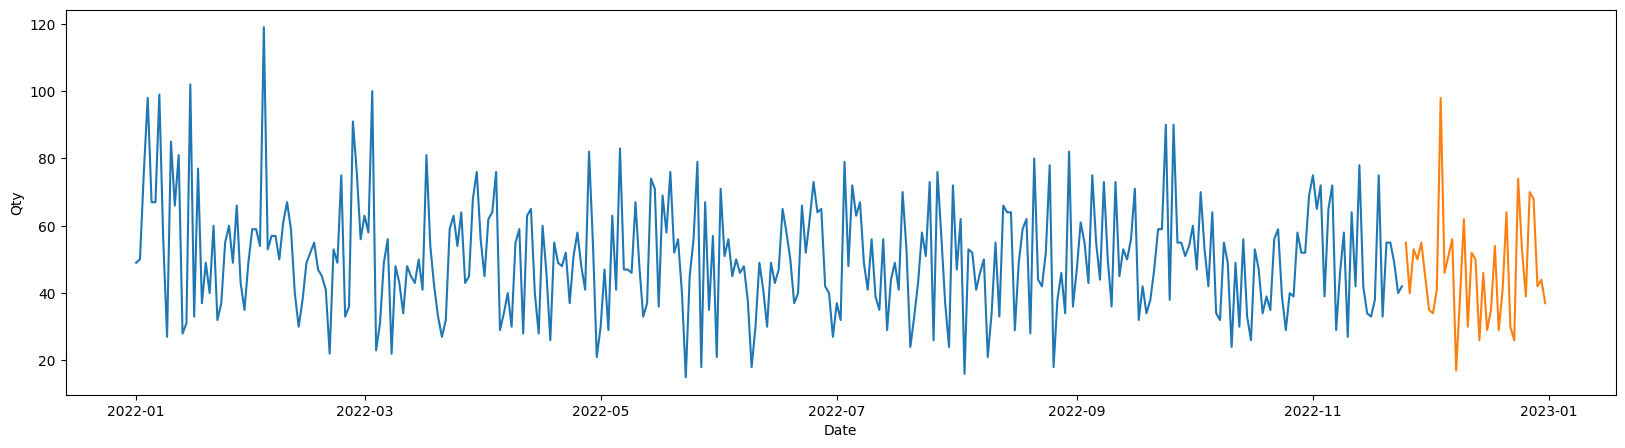

In [54]:
plt.figure(figsize=(20,5))
sns.lineplot(data=df_train, x=df_train['Date'], y=df_train['Qty'])
sns.lineplot(data=df_test, x=df_test['Date'], y=df_test['Qty'])

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

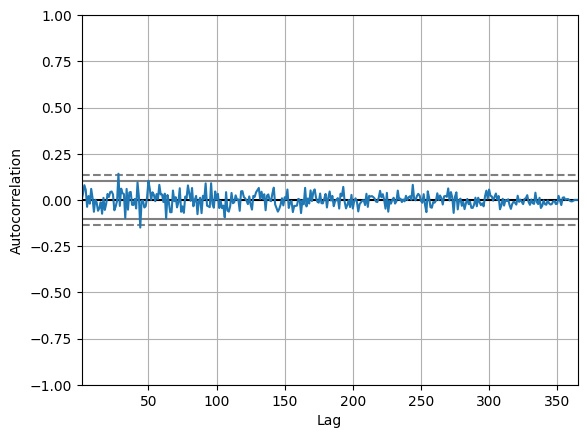

In [55]:
autocorrelation_plot(df_regresi['Qty'])

In [56]:
def rmse(y_actual, y_pred):
  print(f'RMSE Value {mean_squared_error(y_actual, y_pred)*0.5}')
def eval(y_actual, y_pred):
  rmse(y_actual, y_pred)
  print(f'MAX value {mean_absolute_error(y_actual, y_pred)}')

In [57]:
df_train = df_train.set_index('Date')
df_test = df_test.set_index('Date')

In [58]:
y = df_train['Qty']
ARIMAmodel = ARIMA(y, order = (2, 1, 1), seasonal_order=(2, 1, 1, 12))
ARIMAmodel = ARIMAmodel.fit()

In [59]:
y_pred = ARIMAmodel.get_forecast(len(df_test))

In [60]:
y_pred_df = y_pred.conf_int()
y_pred_df['predictions'] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = df_test.index
y_pred_out = y_pred_df['predictions']
eval(df_test['Qty'], y_pred_out)

RMSE Value 120.42533643103488
MAX value 12.021340561948682


Model Prediksi Quantity

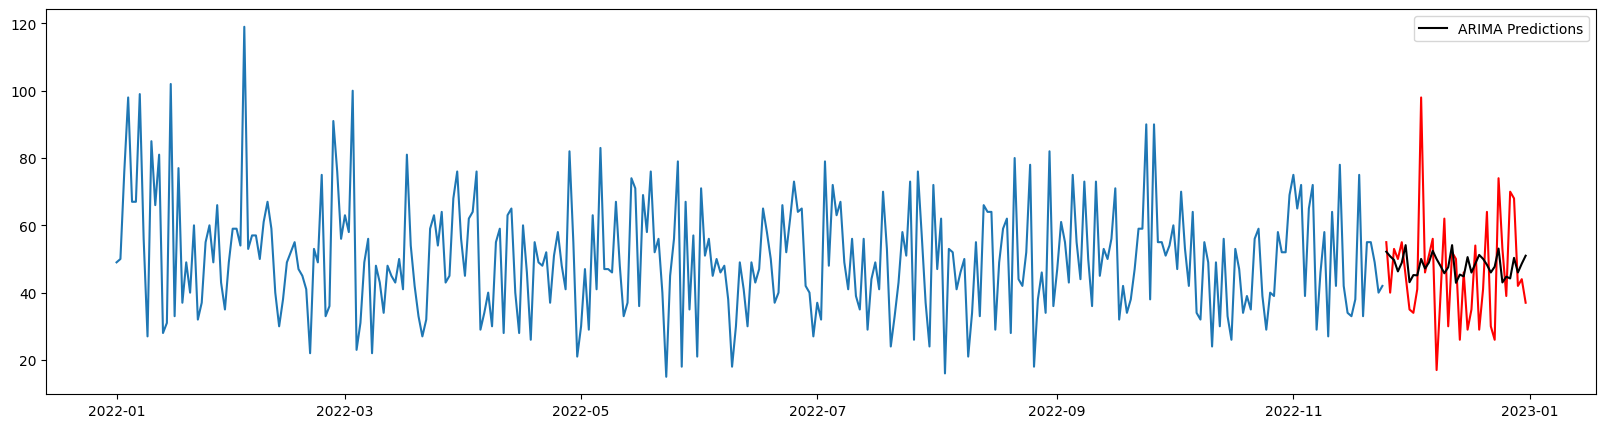

In [61]:
plt.figure(figsize=(20,5))
plt.plot(df_train['Qty'])
plt.plot(df_test['Qty'], color = 'red')
plt.plot(y_pred_out, color = 'black', label = 'ARIMA Predictions')
plt.legend()

Segmentasi Pelanggan

In [63]:
df_merge.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Product Name,StoreName,GroupStore,Type,Latitude,Longitude
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,Married,10.53,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
1,TR89318,183,2022-07-17,P3,7500,1,7500,12,27,1,Single,0.18,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
2,TR9106,123,2022-09-26,P3,7500,4,30000,12,34,0,Married,4.36,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
3,TR4331,335,2022-08-01,P3,7500,3,22500,12,29,1,Single,4.74,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
4,TR6445,181,2022-10-01,P3,7500,4,30000,12,33,1,Married,9.94,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554


In [86]:
df_cluster = df_merge.groupby(['CustomerID']).agg({
    'TransactionID' : 'count',
    'Qty' : 'sum',
    'TotalAmount' : 'sum'
}).reset_index()

In [88]:
df_cluster

,CustomerID,TransactionID,Qty,TotalAmount
0,1,17,60,623300
1,2,13,57,392300
2,3,15,56,446200
3,4,10,46,302500
4,5,7,27,268600
...,...,...,...,...
442,443,16,59,485100
443,444,18,62,577700
444,445,18,68,587200
445,446,11,42,423300


In [89]:
data_cluster = df_cluster.drop(columns=['CustomerID'])
data_cluster_normalize = preprocessing.normalize(data_cluster)

In [90]:
data_cluster_normalize

array([[2.72741856e-05, 9.62618317e-05, 9.99999995e-01],
       [3.31379043e-05, 1.45296965e-04, 9.99999989e-01],
       [3.36172117e-05, 1.25504257e-04, 9.99999992e-01],
       ...,
       [3.06539507e-05, 1.15803814e-04, 9.99999993e-01],
       [2.59862980e-05, 9.92204105e-05, 9.99999995e-01],
       [2.95925334e-05, 9.56066465e-05, 9.99999995e-01]])

In [91]:
K = range(2, 8)
fits = []
score = []

for k in K:
  model = KMeans(n_clusters = k, random_state = 0, n_init='auto').fit(data_cluster_normalize)
  fits.append(model)
  score.append(silhouette_score(data_cluster_normalize, model.labels_, metric = 'euclidean'))

<Axes: >

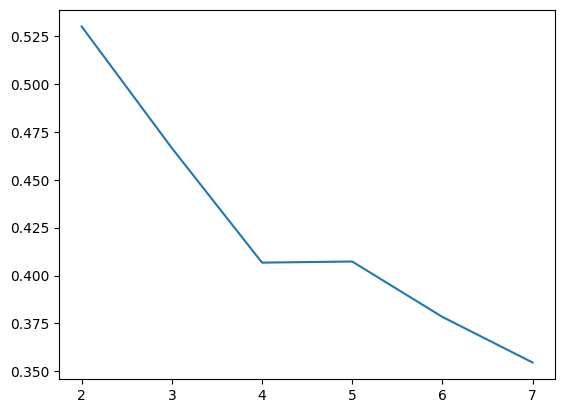

In [92]:
sns.lineplot(x = K, y = score)

In [98]:
df_cluster['cluster_label'] = fits[1].labels_

In [97]:
df_cluster.groupby(['cluster_label']).agg({
    'CustomerID' : 'count',
    'TransactionID' : 'mean',
    'Qty' : 'mean',
    'TotalAmount' : 'mean'
})

,CustomerID,TransactionID,Qty,TotalAmount
cluster_label,,,,
0,205,11.653659,40.882927,409866.829268
1,61,10.344262,39.229508,268652.459016
2,181,11.049724,41.558011,340511.049724
